In [31]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [32]:
BATCH_SIZE = 30
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=20

In [33]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "skin-disease-datasaet",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1125 files belonging to 8 classes.


In [34]:
class_names = dataset.class_names
class_names

['BA- cellulitis',
 'BA-impetigo',
 'FU-athlete-foot',
 'FU-nail-fungus',
 'FU-ringworm',
 'PA-cutaneous-larva-migrans',
 'VI-chickenpox',
 'VI-shingles']

In [35]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(30, 224, 224, 3)
[1 0 6 1 6 4 7 7 2 1 3 7 5 4 5 3 3 3 5 5 0 6 3 0 0 4 7 5 4 3]


In [36]:
train_size = 0.8
len(dataset)*train_size

30.400000000000002

In [37]:
train_ds = dataset.take(30)
len(train_ds)

30

In [38]:
test_ds = dataset.skip(30)
len(test_ds)


8

In [39]:
val_size=0.1
len(dataset)*val_size

3.8000000000000003

In [40]:
val_ds = test_ds.take(3)
len(val_ds)


3

In [41]:
test_ds = test_ds.skip(3)
len(test_ds)

5

In [42]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [43]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (30, 234, 234, 3)         0         
                                                                 
 conv2d (Conv2D)             (30, 232, 232, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (30, 116, 116, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (30, 114, 114, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (30, 57, 57, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (30, 55, 55, 64)         

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
30/30 [==============================] - 24s 706ms/step - loss: 2.0686 - accuracy: 0.1514 - val_loss: 2.0611 - val_accuracy: 0.1333
Epoch 2/20
30/30 [==============================] - 23s 767ms/step - loss: 2.0560 - accuracy: 0.1684 - val_loss: 1.9879 - val_accuracy: 0.2111
Epoch 3/20
30/30 [==============================] - 25s 805ms/step - loss: 2.0202 - accuracy: 0.2090 - val_loss: 2.0483 - val_accuracy: 0.2111
Epoch 4/20
30/30 [==============================] - 26s 860ms/step - loss: 1.9677 - accuracy: 0.2300 - val_loss: 1.8998 - val_accuracy: 0.2222
Epoch 5/20
30/30 [==============================] - 25s 829ms/step - loss: 1.8946 - accuracy: 0.2700 - val_loss: 1.7768 - val_accuracy: 0.2889
Epoch 6/20
30/30 [==============================] - 25s 807ms/step - loss: 1.7430 - accuracy: 0.3389 - val_loss: 1.5800 - val_accuracy: 0.4889
Epoch 7/20
30/30 [==============================] - 26s 841ms/step - loss: 1.5103 - accuracy: 0.4475 - val_loss: 1.4245 - val_accuracy: 0.5111

In [36]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 1s 159ms/step - loss: 0.1984 - accuracy: 0.9400


In [37]:
scores

[0.19836007058620453, 0.9399999976158142]

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.metrics import classification_report

# ... (Your previous code)

# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f'Test accuracy: {test_acc}')

# Predict labels for the test set
predictions = model.predict(test_ds)

# Convert predictions to class labels
predicted_labels = tf.argmax(predictions, axis=1)

# Get true labels from the test set
true_labels = tf.concat([y for x, y in test_ds], axis=0)

# Convert to numpy arrays for classification_report
predicted_labels_np = predicted_labels.numpy()
true_labels_np = true_labels.numpy()

# Generate and print classification report
class_report = classification_report(true_labels_np, predicted_labels_np, target_names=class_names)
print("Classification Report:\n", class_report)


In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


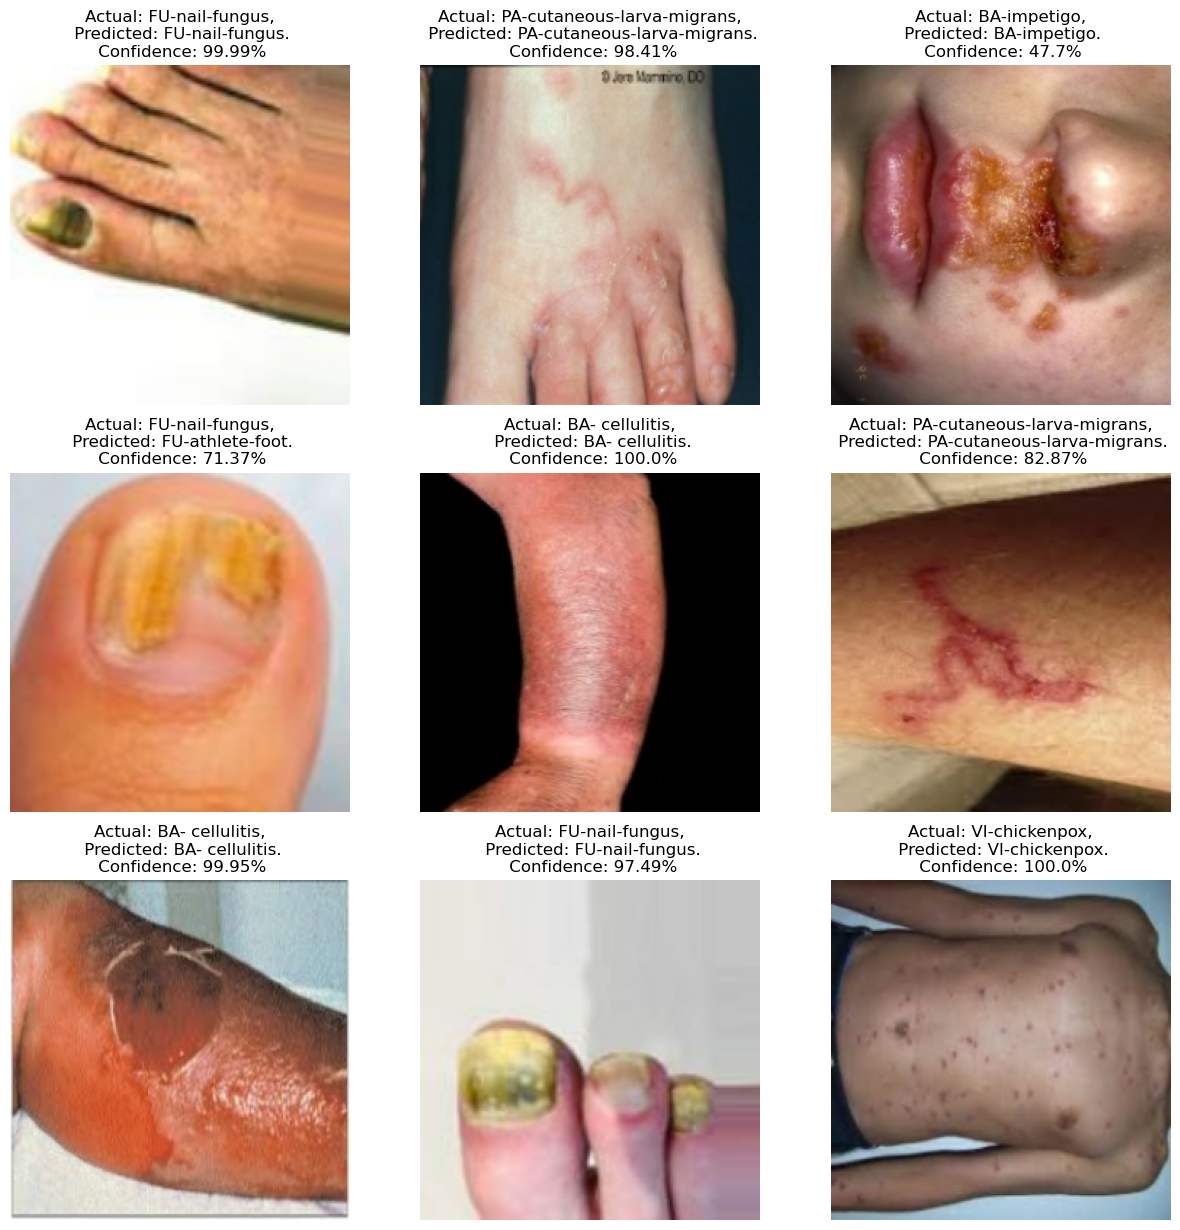

In [31]:
import numpy as np 
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

       

first image to predict
actual label: VI-shingles
1/1 [==============================] - 0s 185ms/step
predicted label: VI-shingles


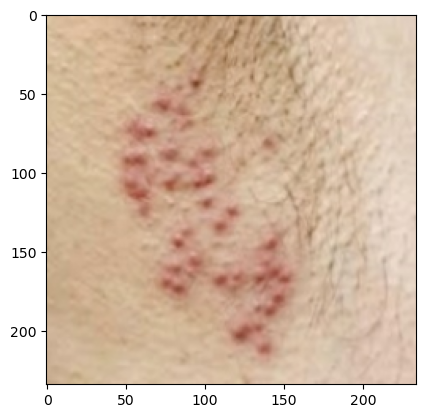

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [ ]:
import os
directory_path = "../models3"

# Check if the directory exists, if not, create it
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

model_version=max([int(i) for i in os.listdir("../models3") + [0]])+1
model.save(f"models3/{model_version}")

In [ ]:
model.save("../skin.h5")

In [46]:
import tensorflow as tf
from tensorflow.keras import models
from sklearn.metrics import classification_report

# Assuming you have already trained your model and saved it to an h5 file
# If you haven't saved it yet, you can do so using: model.save("your_model.h5")

# Load the saved model from the h5 file
loaded_model = models.load_model("my_.h5")

# Evaluate the model on the test set
test_loss, test_acc = loaded_model.evaluate(train_ds, verbose=2)
print(f'Test accuracy: {test_acc}')

# Predict labels for the test set
predictions = loaded_model.predict(train_ds)

# Convert predictions to class labels
predicted_labels = tf.argmax(predictions, axis=1)

# Get true labels from the test set
true_labels = tf.concat([y for x, y in train_ds], axis=0)

# Convert to numpy arrays for classification_report
predicted_labels_np = predicted_labels.numpy()
true_labels_np = true_labels.numpy()
A
# Generate and print classification report
class_report = classification_report(true_labels_np, predicted_labels_np, target_names=class_names)
print("Classification Report:\n", class_report)


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\ProgramData\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\ProgramData\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\ProgramData\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\ProgramData\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\ProgramData\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\ProgramData\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\ProgramData\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\sumit\AppData\Local\Temp\ipykernel_14768\2542796079.py", line 12, in <module>

  File "C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2272, in evaluate

  File "C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 4079, in run_step

  File "C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2042, in test_function

  File "C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2025, in step_function

  File "C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2013, in run_step

  File "C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1895, in test_step

  File "C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1185, in compute_loss

  File "C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 143, in __call__

  File "C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 270, in call

  File "C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 2454, in sparse_categorical_crossentropy

  File "C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\backend.py", line 5777, in sparse_categorical_crossentropy

Received a label value of 7 which is outside the valid range of [0, 6).  Label values: 2 2 3 2 2 1 1 3 3 6 0 6 4 4 7 5 5 4 7 4 5 3 3 7 4 0 3 0 2 4
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_test_function_13834]